# Convert NDVI process graph to evalscript
Import the required processes and libraries. `from pg_to_evalscript import convert_from_process_graph` loads the library that this notebook is part of.

In [1]:
import json

import openeo
from openeo.processes import array_element, normalized_difference
from pg_to_evalscript import convert_from_process_graph
from sentinelhub import BBox, CRS, DownloadRequest, SentinelHubDownloadClient, MimeType, SHConfig
import numpy as np
import matplotlib.pyplot as plt
import jsbeautifier

Connect to the openEO backend (2) to create a datacube (3).

In [2]:
c = openeo.connect("https://openeo.vito.be/openeo/1.0")

In [3]:
datacube = c.load_collection(
    "SENTINEL2_L2A_SENTINELHUB", bands=["B08", "B04"], temporal_extent=["2021-08-01", "2021-08-04"]
)

Define NDVI function and create a process graph.

In [4]:
def ndvi_function(data):
    B04 = array_element(data, index = 1) # array_element takes either an index ..
    B08 = array_element(data, label = "B08") # or a label

    # ndvi = (B08 - B04) / (B08 + B04) # implement NDVI as formula ..
    ndvi = normalized_difference(B08, B04) # or use the openEO "normalized_difference" process
    
    return ndvi

datacube_ndvi = datacube.reduce_dimension(reducer = ndvi_function, dimension = "bands")

Convert process graph into json format and load into variable.

In [5]:
process_graph_ndvi = json.loads(datacube_ndvi.to_json())["process_graph"]

Convert process graph into an evalscript and print info about the created evalscript. The 'invalid_node_id' tells us up to which node the process graph could be converted. If it's "None", the whole process graph could be converted into an evalscript.

In [6]:
subgraph_evalscripts = convert_from_process_graph(process_graph_ndvi)
print(subgraph_evalscripts)

[{'evalscript': <pg_to_evalscript.evalscript.Evalscript object at 0x000001E94E02EF70>, 'invalid_node_id': None}]


Generate evalscript string and print readable version.

In [6]:
evalscript = subgraph_evalscripts[0]['evalscript']
evalscript_string = evalscript.write()
print(jsbeautifier.beautify(evalscript_string))

//VERSION=3
function setup() {
    return {
        input: ['B08', 'B04'],
        output: {
            bands: 1,
            sampleType: "FLOAT32"
        },
        mosaicking: "ORBIT"
    };
}

function updateOutput(outputs, collection) {
    Object.values(outputs).forEach((output) => {
        output.bands = 1 + 1 * collection.scenes.length;
    });
}
class DataCube {
    constructor(data, bands_dimension_name, temporal_dimension_name, fromSamples) {
        this.TEMPORAL = "temporal"
        this.BANDS = "bands"
        this.OTHER = "other"
        this.bands_dimension_name = bands_dimension_name;
        this.temporal_dimension_name = temporal_dimension_name;
        this.dimensions = [{
            name: this.temporal_dimension_name,
            labels: [],
            type: this.TEMPORAL
        }, {
            name: this.bands_dimension_name,
            labels: [],
            type: this.BANDS
        }]
        if (fromSamples) {
            this.data = this.makeArrayFromS

## Check validity of the evalscript
Create SH request and send the created evalscript to SH to confirm that a working script was generated (SH CLIENT_ID and CLIENT_SECRET have to be filled in).

In [7]:
config = SHConfig()
CLIENT_ID=""
CLIENT_SECRET=""
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

width = 100
height = 100
mimetype = MimeType.TIFF 
request_raw_dict = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/3857"},
                "bbox": [
            1369751.5468703588,
            5165920.119625352,
            1379535.486490861,
            5175704.059245855
         ],
            },
            "data": [
                {
                    "type": "S2L2A",
                    "dataFilter": {
                        "timeRange": {
                            "from":"2021-08-01T00:00:00.000Z",
                              "to":"2021-08-04T23:59:59.999Z"
                        },
                        "mosaickingOrder": "mostRecent",
                        "previewMode": "EXTENDED_PREVIEW",
                        "maxCloudCoverage": 100,
                    },
                    "processing": {"view": "NADIR"},
                }
            ],
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{"identifier": "default", "format": {"type": mimetype.get_string()}}],
        },
        "evalscript": evalscript_string,
    }


download_request = DownloadRequest(
    request_type="POST",
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_raw_dict,
    data_type=mimetype,
    headers={"content-type": "application/json"},
    use_session=True,
)

download_request.raise_if_invalid()

client = SentinelHubDownloadClient(config=config)
image = client.download(download_request)

In [8]:
decoding_function = evalscript.get_decoding_function()
decoded_image = decoding_function(image.tolist())

Print image for the 1st available time stamp (0:1)

(100, 100, 2)


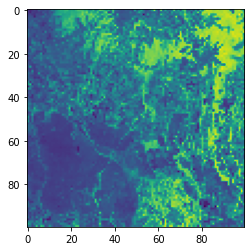

In [9]:
b = np.array(decoded_image)
print(b.shape)
plt.imshow(b[:,:,0:1])